# Anticancer Peptide (ACP) recognition using the SGT

Sequence Graph Transform (SGT) is used for Sequence Embedding.
<br>
SGT reference: https://github.com/cran2367/sgt
<br>
SGT overview: https://towardsdatascience.com/sequence-embedding-for-clustering-and-classification-f816a66373fb

## All necessary imports

In [1]:
import sgt
from sgt import SGT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

np.random.seed(7)  # for reproducibility
sgt.__version__

'2.0.3'

## Reading the ACP data

In [2]:
# Loading data
df = pd.read_csv('../data_instadeep/acp/train_data.csv')
print(df.shape)

(1378, 2)


There are 1,378 samples.

In [3]:
df.head(5)

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1


In [4]:
df.sample(5)

,sequences,label
324,PRFWEYWLRAME,1
587,KWKLFKKIPKFLHLAK,1
13,FAKLLFKALKKAL,1
170,GLLSFLPKVIGVIGHLIHPPS,0
450,VNWKKLLGKLLKVVK,1


In [5]:
df.dtypes

sequences    object
label         int64
dtype: object

In [6]:
print(f'{"Column":15s} # of unique values')
print(f'{"-"*40:60s}')
for col in df:
    print(f'{col:15s} {len(df[col].unique())}')

Column          # of unique values
----------------------------------------                    
sequences       1378
label           2


There are no duplicates.

In [7]:
# Any None entries?
df.isna().sum()

sequences    0
label        0
dtype: int64

In [8]:
# Is the data balanced?
df['label'].value_counts(normalize=True)

0    0.5
1    0.5
Name: label, dtype: float64

The data is balanced.

## Protein Sequence Clustering

In [9]:
df.columns

Index(['sequences', 'label'], dtype='object')

In [10]:
# Add an id column
df["id"] = list(range(df.shape[0]))
df.head()

,sequences,label,id
0,RRWWRRWRRW,0,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,1
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,2
3,GLFDVIKKVAAVIGGL,1,3
4,VAKLLAKLAKKVL,1,4


In [11]:
# Data preprocessing
df_pca = df.loc[:, ['id', 'sequences']]
print(df_pca.head())

df_pca.columns = ['id', 'sequence']
df_pca['sequence'] = df_pca['sequence'].map(list)
df_pca

   id                           sequences
0   0                          RRWWRRWRRW
1   1          GWKSVFRKAKKVGKTVGGLALDHYLG
2   2  ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ
3   3                    GLFDVIKKVAAVIGGL
4   4                       VAKLLAKLAKKVL


,id,sequence
0,0,"[R, R, W, W, R, R, W, R, R, W]"
1,1,"[G, W, K, S, V, F, R, K, A, K, K, V, G, K, T, ..."
2,2,"[A, L, W, K, T, M, L, K, K, L, G, T, M, A, L, ..."
3,3,"[G, L, F, D, V, I, K, K, V, A, A, V, I, G, G, L]"
4,4,"[V, A, K, L, L, A, K, L, A, K, K, V, L]"
...,...,...
1373,1373,"[L, L, K, L, L, K, W, L, L, K, L, L, K]"
1374,1374,"[G, F, K, D, W, I, K, G, A, A, K, K, L, I, K, ..."
1375,1375,"[E, S, E, F, D, R, Q, E, Y, E, E, C, K, R, Q, ..."
1376,1376,"[F, I, S, A, I, A, S, F, L, G, K, F, L]"


In [12]:
%%time
# Compute SGT embeddings
sgt_ = SGT(kappa=1, lengthsensitive=False)
sgtembedding_df = sgt_.fit_transform(df_pca)

CPU times: user 5.83 s, sys: 83 ms, total: 5.91 s
Wall time: 6 s


In [13]:
sgtembedding_df

,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,1.0,0.000017,0.0,0.067669,0.0,0.000000,0.004251,0.024894,0.000000,0.169984,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2,2.0,0.052288,0.0,0.069555,0.0,0.000000,0.033983,0.067668,0.009413,0.032185,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
3,3.0,0.367879,0.0,0.000000,0.0,0.000000,0.023289,0.000000,0.092561,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4,4.0,0.023005,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.141247,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,1373.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1374,1374.0,0.080450,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.035033,0.116259,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1375,1375.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000168,0.067668,0.0,0.008732,0.001685,7.536959e-07,0.000006,2.061154e-09,4.658886e-15,2.319523e-16
1376,1376.0,0.135335,0.0,0.000000,0.0,0.039116,0.010397,0.000000,0.367879,0.003825,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00


This is the embedding generated using the SGT.

In [14]:
# Set the id column as the dataframe index
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1.0,0.000017,0.0,0.067669,0.0,0.000000,0.004251,0.024894,0.000000,0.169984,0.074934,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2.0,0.052288,0.0,0.069555,0.0,0.000000,0.033983,0.067668,0.009413,0.032185,0.124865,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
3.0,0.367879,0.0,0.000000,0.0,0.000000,0.023289,0.000000,0.092561,0.000000,0.004608,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4.0,0.023005,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.141247,0.048883,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1374.0,0.080450,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.035033,0.116259,0.034051,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1375.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000168,0.067668,0.0,0.008732,0.001685,7.536959e-07,0.000006,2.061154e-09,4.658886e-15,2.319523e-16


We perform PCA on the sequence embeddings and then do k-means clustering.

In [15]:
# Number of components vs explained variance %
nc_all = sgtembedding_df.shape[1] - 1  # = total nc (number of components)
x_nc = []  # nc = no of components
y_ev = []  # ev = explained variance %
for n in range(1, nc_all + 1):
    pca = PCA(n_components=n)
    pca.fit(sgtembedding_df)
    x_nc.append(n)
    y_ev.append(np.sum(pca.explained_variance_ratio_))

Text(0, 0.5, 'explained variance %')

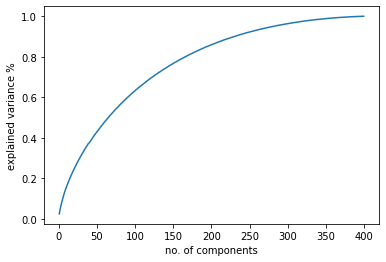

In [16]:
plt.plot(x_nc, y_ev)
plt.xlabel('no. of components')
plt.ylabel('explained variance %')

In [17]:
pca = PCA(n_components=2)
pca.fit(sgtembedding_df)
X=pca.transform(sgtembedding_df)
print(f'Explained variance with only the first 2 components: {np.sum(pca.explained_variance_ratio_): .3f}')

Explained variance with only the first 2 components:  0.046


In [18]:
df_kmeans = pd.DataFrame(data=X, columns=['x1', 'x2'])
df_kmeans.head(5)

,x1,x2
0,0.043324,-0.162609
1,0.060138,-0.020534
2,0.059979,-0.025385
3,0.097497,0.403473
4,0.160726,-0.049033


In [19]:
df_kmeans['label'] = df['label']
df_kmeans

,x1,x2,label
0,0.043324,-0.162609,0
1,0.060138,-0.020534,0
2,0.059979,-0.025385,1
3,0.097497,0.403473,1
4,0.160726,-0.049033,1
...,...,...,...
1373,0.157459,-0.160413,0
1374,0.095690,0.133575,0
1375,-0.094454,-0.124260,0
1376,0.142502,0.202807,1


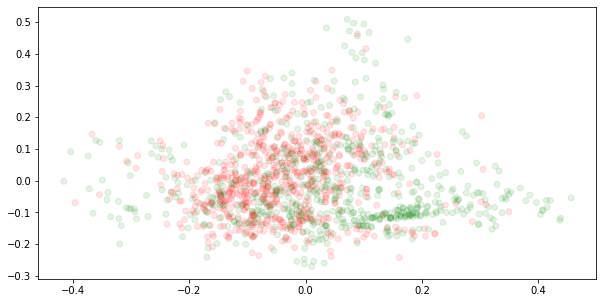

In [20]:
labels = df_kmeans['label']

fig = plt.figure(figsize=(10, 5))
colmap = {0: 'r', 1: 'g'}
colors = list(map(lambda x: colmap[x], labels))
plt.scatter(df_kmeans['x1'], df_kmeans['x2'], color=colors, alpha=0.1, edgecolor=colors)

In 2D, the negative examples (in red) and the positive examples (in green) do not separate well.

In [21]:
df_kmeans = pd.DataFrame(data=X, columns=['x1', 'x2'])
df_kmeans

,x1,x2
0,0.043324,-0.162609
1,0.060138,-0.020534
2,0.059979,-0.025385
3,0.097497,0.403473
4,0.160726,-0.049033
...,...,...
1373,0.157459,-0.160413
1374,0.095690,0.133575
1375,-0.094454,-0.124260
1376,0.142502,0.202807


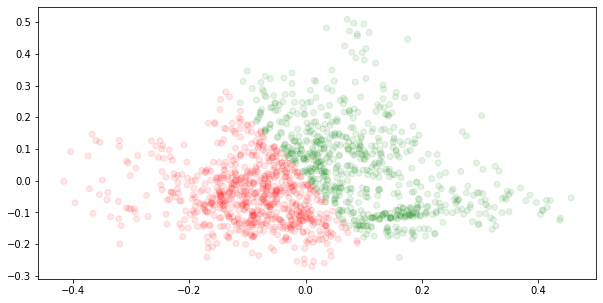

In [22]:
kmeans = KMeans(n_clusters=2, max_iter =300)
kmeans.fit(df_kmeans)

labels = kmeans.predict(df_kmeans)

fig = plt.figure(figsize=(10, 5))
colmap = {1: 'r', 2: 'g'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df_kmeans['x1'], df_kmeans['x2'], color=colors, alpha=0.1, edgecolor=colors)

Kmeans with 2 clusters does not separate the data well. This was expected as this was done with only the first 2 components from the PCA, which has a very low explained variance of 0.046.

## Sequence Classification using Deep Learning

In [2]:
# Loading data
data = pd.read_csv('../data_instadeep/acp/train_data.csv')
data.head()

,sequences,label
0,RRWWRRWRRW,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1
3,GLFDVIKKVAAVIGGL,1
4,VAKLLAKLAKKVL,1


In [3]:
# add an id column
data["id"] = list(range(data.shape[0]))
data.head()

,sequences,label,id
0,RRWWRRWRRW,0,0
1,GWKSVFRKAKKVGKTVGGLALDHYLG,0,1
2,ALWKTMLKKLGTMALHAGKAALGAAADTISQGTQ,1,2
3,GLFDVIKKVAAVIGGL,1,3
4,VAKLLAKLAKKVL,1,4


In [4]:
# shuffle the rows
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
data = data.sample(frac=1, random_state=42)
print(data.shape)
data.head(5)

(1378, 3)


,sequences,label,id
597,GLFDIVKKIAGHIVSSI,1,597
700,KLKNFAKGVAQSLLNKASCKLSGQC,1,700
1222,GLWNSIKIAGKKLFVNVLDKIRCKVAGGCKTSPDVE,0,1222
1145,GAFGNFLKGVAKKAGLKILSIAQCKLFGTC,1,1145
602,INLKAIAALAKKLLG,0,602


In [5]:
# Data preprocessing
y = np.array(data['label'])

corpus = data.loc[:,['id', 'sequences']]
corpus.columns = ['id', 'sequence']
corpus['sequence'] = corpus['sequence'].map(list)
corpus

,id,sequence
597,597,"[G, L, F, D, I, V, K, K, I, A, G, H, I, V, S, ..."
700,700,"[K, L, K, N, F, A, K, G, V, A, Q, S, L, L, N, ..."
1222,1222,"[G, L, W, N, S, I, K, I, A, G, K, K, L, F, V, ..."
1145,1145,"[G, A, F, G, N, F, L, K, G, V, A, K, K, A, G, ..."
602,602,"[I, N, L, K, A, I, A, A, L, A, K, K, L, L, G]"
...,...,...
1095,1095,"[G, V, V, T, D, L, L, N, T, A, G, G, L, L, G, ..."
1130,1130,"[A, T, C, D, L, A, S, G, F, G, V, G, S, S, L, ..."
1294,1294,"[G, L, I, S, G, I, L, G, V, G, K, K, L, V, C, ..."
860,860,"[T, T, K, N, Y, G, N, G, V, C, N, S, V, N, W, ..."


In [6]:
# Sequence embedding
sgt_ = SGT(kappa=1, lengthsensitive=False)
sgtembedding_df = sgt_.fit_transform(corpus)
X = sgtembedding_df.set_index('id')
X

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
597.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.367879,0.135335,0.025349,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
700.0,6.414741e-03,0.022633,0.000000,0.000000,0.000000,0.034454,0.000000,0.000000,0.070039,0.012526,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1222.0,4.139938e-08,0.016596,0.000127,0.000023,0.006738,0.174219,0.000000,0.000006,0.033909,0.009220,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1145.0,8.378131e-03,0.016965,0.000000,0.000000,0.065489,0.058325,0.000000,0.003364,0.050652,0.015837,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
602.0,1.241437e-01,0.000000,0.000000,0.000000,0.000000,0.002008,0.000000,0.367879,0.074970,0.054791,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.102016,0.000000,0.000000,0.000000,0.017258,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1130.0,2.664669e-02,0.019771,0.049787,0.000000,0.025061,0.010414,0.125804,0.017026,0.000003,0.006147,...,0.0,0.034458,0.0,0.000000,0.122642,0.025349,0.000000e+00,0.000716,0.000000,0.018316
1294.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000


We will perform a 10-fold cross-validation to choose the best model.

In [7]:
kfold = 10
random_state = 1

xval_accuracy = np.zeros(kfold)
xval_recall = np.zeros(kfold)
xval_f1 = np.zeros(kfold)
skf = KFold(n_splits = kfold, shuffle = True, random_state = random_state)
k = 0
epochs = 50
batch_size = 128

models = []
for train_index, xval_index in skf.split(X, y):
    X_train, X_xval = X.iloc[train_index], X.iloc[xval_index]
    y_train, y_xval = y[train_index], y[xval_index]
    
    model = Sequential()
    model.add(Dense(64, input_shape = (X_train.shape[1],), activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    models.append(model)
    
    y_pred = model.predict(X_xval).round().astype(int)


    xval_accuracy[k] = sklearn.metrics.accuracy_score(y_xval, y_pred)
    xval_recall[k] = sklearn.metrics.recall_score(y_xval, y_pred)
    xval_f1[k] = sklearn.metrics.f1_score(y_xval, y_pred)
    k+=1
    
print ('Average accuracy score', np.mean(xval_accuracy))
print ('Average recall score', np.mean(xval_recall))
print ('Average f1 score', np.mean(xval_f1))

2022-10-05 23:20:42.060438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 0s 2ms/step
Average accuracy score 0.7090394583730033
Average recall score 0.6957404495215969
Average f1 score 0.7043878592867674


For the given problem, accuracy seems like a good metric. With this simple SGT we achieved a 70.9% accuracy.